<a href="https://colab.research.google.com/github/gayoooon1/2021-RecSys/blob/main/Popular_Genre_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Popular, Genre, Group based recommendation

몇가지 보완 사항을 공유합니다.
1. 우리가 사용한 데이터는 implicit feedback 데이터인데, 원래 데이터는 explicit feedback 이였습니다. 이것을 조금더 reasonable 하게 하기 위해 리뷰 점수가 3이상인 것들만 1로 binarize 함   
2. group recommender:  이용자의 정보 (나이 직업)을 활용한 추천 시스템 만들어보기
쟝르 모델과 비교하기 (1번에 대해 데이터가 바뀌었다면, 지금까지 한 작업들을 다시 반복하여 3개의 모델: popular, genre, group 모델 성능비교 수행)

## 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/DEEPLEARNING/ml-1m

/content/drive/MyDrive/DEEPLEARNING/ml-1m


In [ ]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings(action='ignore')

In [ ]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
movies = pd.read_csv('movies.dat', header=None, sep='::', names=["movie_id", "title", "genres"], encoding='latin-1', engine='python')
ratings = pd.read_csv('ratings.dat', header=None, sep='::', names = ['user_id', 'movie_id', 'rating', 'unix_timestamp'], encoding='latin-1', engine='python')
users = pd.read_csv('users.dat',  header=None, sep='::', names=['user_id', 'sex', 'age', 'occupation', 'zip_code'],encoding='latin-1', engine='python', index_col = 'user_id')

In [ ]:
movies = pd.read_csv('movies.dat', header=None, sep='::', names=["movie_id", "title", "genres"], encoding='latin-1', engine='python')

In [ ]:
users.isnull().sum()

sex           0
age           0
occupation    0
zip_code      0
dtype: int64

In [ ]:
sex_mapping = {'M':0, 'F':1}
users['sex'] = users['sex'].map(sex_mapping)
users.head()

,sex,age,occupation,zip_code
user_id,,,,
1,1,1,10,48067
2,0,56,16,70072
3,0,25,15,55117
4,0,45,7,02460
5,0,25,20,55455


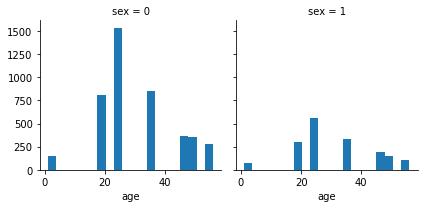

In [ ]:
g = sns.FacetGrid(users, col = 'sex')
g.map(plt.hist, 'age', bins=20)

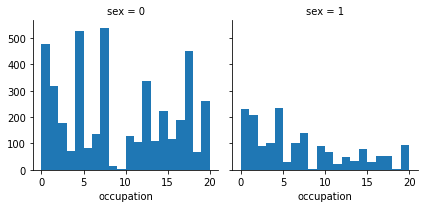

In [ ]:
g = sns.FacetGrid(users, col = 'sex')
g.map(plt.hist, 'occupation', bins=20)

나이를 크게 0-20, 20-40, 40- 이렇게 나눌 수 있겠다.

In [ ]:
users.drop('zip_code', axis=1, inplace=True)

In [ ]:
def age_detect(n):
  if (n>0) & (n<21):
    n=0
    return n
  elif (n>20) & (n<41):
    n=1
    return n
  else: 
     n=2
     return n

In [ ]:
users['age'] = users['age'].apply(age_detect)

In [ ]:
users.head()

,sex,age,occupation
user_id,,,
1,1,0,10
2,0,2,16
3,0,1,15
4,0,2,7
5,0,1,20


In [ ]:
ratings = ratings[ratings['rating']>2]
ratings.drop('unix_timestamp',axis=1, inplace=True)

In [ ]:
ratings.rating = 1

In [ ]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1


## Train, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size = 0.05, random_state = 42)

In [ ]:
train.head()

,user_id,movie_id,rating
610058,3697,16,1
100967,673,3535,1
886328,5353,2872,1
346559,2031,912,1
688622,4118,1954,1


## Group

In [ ]:
group_base = pd.merge(train,users, on='user_id')

In [ ]:
group_base.set_index('user_id')

,movie_id,rating,sex,age,occupation
user_id,,,,,
3697,16,1,0,1,15
3697,1387,1,0,1,15
3697,2140,1,0,1,15
3697,2694,1,0,1,15
3697,2701,1,0,1,15
...,...,...,...,...,...
572,3623,1,0,0,4
572,3408,1,0,0,4
572,3861,1,0,0,4


In [ ]:
# age 0,1,2
# sex 0,1
# total 6 경우의 수
m_low = group_base[(group_base['age']==0) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_low = group_base[(group_base['age']==0) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
m_mid = group_base[(group_base['age']==1) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_mid = group_base[(group_base['age']==1) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
m_high = group_base[(group_base['age']==2) & group_base['sex']==0].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()
f_high =  group_base[(group_base['age']==2) & group_base['sex']==1].groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()

In [ ]:
group_test = pd.merge(test,users, on='user_id')
group_test.drop('occupation',axis=1,inplace=True)
group_test.head()

,user_id,movie_id,rating,sex,age
0,1141,596,1,1,1
1,1141,926,1,1,1
2,1141,3897,1,1,1
3,1141,933,1,1,1
4,1141,1073,1,1,1


In [ ]:
group_test.drop('rating',axis=1,inplace=True)

In [ ]:
group_test.set_index('user_id')

,movie_id,sex,age
user_id,,,
1141,596,1,1
1141,926,1,1
1141,3897,1,1
1141,933,1,1
1141,1073,1,1
...,...,...,...
1508,2028,1,0
2925,3753,1,1
4545,2571,0,1


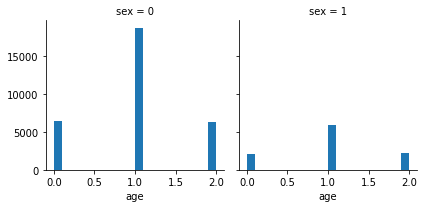

In [ ]:
g = sns.FacetGrid(group_test, col = 'sex')
g.map(plt.hist, 'age', bins=20)

In [ ]:
#group_test[(group_test['age']==0) & (group_test['sex']==0)]['movie_id'].tolist()

In [ ]:
tml = group_test[(group_test['age']==0) & (group_test['sex']==0)]['movie_id'].tolist()
tfl = group_test[(group_test['age']==0) & (group_test['sex']==1)]['movie_id'].tolist()
tmm = group_test[(group_test['age']==1) & (group_test['sex']==0)]['movie_id'].tolist()
tfm = group_test[(group_test['age']==1) & (group_test['sex']==1)]['movie_id'].tolist()
tmh = group_test[(group_test['age']==2) & (group_test['sex']==0)]['movie_id'].tolist()
tfh =  group_test[(group_test['age']==2) & (group_test['sex']==1)]['movie_id'].tolist()

In [ ]:
len(tml) + len(tfl) + len(tmm) +len(tfm)+len(tmh)+len(tfh)

41824

In [ ]:
len(group_test)

41824

In [ ]:
def hitrate50_group():
  hit = 0
  for a in tml:
    if a in m_low:
      hit +=1
  for b in tfl:
    if b in f_low:
      hit +=1
  for c in tmm:
    if c in m_mid:
      hit +=1
  for d in tfm:
    if d in f_mid:
      hit +=1
  for e in tmh:
    if e in m_high:
      hit +=1
  for f in tfh:
    if f in f_high:
      hit +=1
  return ((hit/len(group_test))) * 100

In [ ]:
print('%.2f%%' %(hitrate50_group()))

12.84%


Grouping 결과 12.84% 예측 🙄.............   
age를 시각화해서 나뉘어지는 3범주로 0,1,2로 나누었고, sex 0,1 두 범주로 나누어 총 6가지 경우의 수를 가지고 가장 많이 본 영화 top 50 추출, test set에 적용하였음

## Genre

In [ ]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# The movies file contains a binary feature for each genre.
genre_cols = [
    "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

In [ ]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))

In [ ]:
movies.genres = movies.genres.str.split('|')

In [ ]:
for a in genre_cols:
  movies[a] = movies[a].replace({True: 1, False: 0})

In [ ]:
movies.head()

,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.set_index('user_id')
train.drop('rating', axis=1, inplace=True)
train = pd.merge(train, movies, on='movie_id')

In [ ]:
train[train['user_id']==3697].groupby('Adventure').size()

Adventure
0    73
1    43
dtype: int64

In [ ]:
def rec_movies(uid):
  favg = dict()
  for a in genre_cols:
    try: favg[a] = train[train['user_id']==uid].groupby(a).size()[1]
    except KeyError: continue
  favgl = sorted(favg, key=favg.get, reverse=True)[:5]
  ranking = []
  for a in favgl:
    ranking.append(train[train[a]==1].groupby('movie_id').size().sort_values(ascending=False)[:10].tolist())
  return sum(ranking, [])

In [ ]:
test = test[['user_id', 'movie_id']]
test = test.set_index('user_id')

In [ ]:
def find_watched_list(uid):
  for a in test['movie_id'].groupby('user_id'):
    if a[0] == uid:
      return a[1].tolist()

In [ ]:
def hitrate50_genre(df):
  hit = 0
  for tmp in df.index:
    rec_list = rec_movies(tmp)
    watch = find_watched_list(tmp)
    for e in watch:
      if e in rec_list:
        hit+=1
  print(hit)
  return (hit/len(test)) * 100

In [ ]:
print('%.2f%%' %(hitrate50_genre(test)))

7438
17.78%


장르의 경우 지난 주의 것보다 조금 더 보완해서 진행, 장르를 unique하게 모두 자르고 유저가 좋아하는 장르 5개를 고른뒤 각 장르별 많이 본 영화를 10개씩 추천한 뒤(총 50개) 유저가 실제로 본 영화와 얼마나 매치하는지 hit을 계산했다 😊 

## Popular

In [ ]:
top_50 = train.groupby('movie_id').size().sort_values(ascending=False).index[:50].tolist()

In [ ]:
movie_list = test['movie_id'].tolist()

In [ ]:
def hitrate50_popular():
  hit = 0
  for a in movie_list:
    if a in top_50:
      hit+=1
  return (hit/len(movie_list)) * 100

In [ ]:
print('%.2f%%' %(hitrate50_popular()))

12.50%


## Conclusion   
group : 12.84%   
genre : 17.78%   
popular : 12.50%   

genre > group > popular 순으로 정확도가 높은 것을 알 수 있었다. 하지만 장르 추천 시스템은 돌리는데 시간이 엄청 오래걸렸다...🤔